## Prepare the workspace

In [1]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
import numpy as np
import pandas as pd
import os
import random
import time
from PIL import Image  # For image handling
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import tensor
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import argparse
from collections import OrderedDict
import json
import PIL

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

**Method 1**
```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


**Method 2**
```bash
!cp -r /data/ .
```

## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


valid_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize to 256 pixels
    transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
# TODO: Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,drop_last=True)

In [5]:
train_loader_size= len(train_loader)
valid_loader_size= len(valid_loader)
test_loader_size= len(test_loader)

train_loader_size, valid_loader_size, test_loader_size

(204, 25, 25)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. 

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [7]:
# TODO: Build and train your network
model= models.vgg16(pretrained=True)

#When a model is loaded in PyTorch, all its parameters have their ‘requires_grad‘ field set to true by default. 
#That means each and every change to the parameter values will be stored in order to be used in the back propagation graph 
#used for training. This increases memory requirements. So,
#since most of the parameters in our pre-trained model are already trained for us, we reset the requires_grad field to false.

#to freeze part of the convolutional part of vgg16 model and train the rest
for param in model.parameters():
    param.requires_grad = False
    
#Then we replace the final layer of the vgg16 model by a small set of Sequential layers. 
#The inputs to the last fully connected layer of vgg16 is fed to a Linear layer, 
#which are then fed into ReLU (rectified linear unit) and Dropout layers.

from collections import OrderedDict
num_classes=102
classifier = nn.Sequential(OrderedDict([
    ('hidden_layer1', nn.Linear(25088, 512)),  
    ('relu1', nn.ReLU()),  
    ('hidden_layer2', nn.Linear(512, 256)),  
    ('relu2', nn.ReLU()),  
    ('output', nn.Linear(256, 102)),  
    ('log_softmax', nn.LogSoftmax(dim=1))  
]))

model.classifier=classifier

#conversion model to be used on GPU
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
criterion=nn.NLLLoss()
optimizer= optim.Adam(model.classifier.parameters(), lr=1e-3)
model.to(device)

inputs, labels = next(iter(train_loader))
inputs, labels = inputs.to('cuda'), labels.to('cuda')
outputs = model(inputs)
print("Model output shape:", outputs.shape)  # Should be [batch_size, 102]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 311MB/s]  


Model output shape: torch.Size([32, 102])


In [8]:
'''
Training is carried out for a fixed set of epochs, processing each image once in a single epoch.
The training data loader loads data in batches.
In our case, we have given a batch size of 32, which means each batch can have at most 32 images.
with transfer learning, we need to compute gradients only for a small set of parameters 
that belong to the few newly added layers towards the end of the model.

Gradient computation is done using the autograd and back propagation.
PyTorch accumulates all the gradients in the backward pass. 
So it is essential to zero them out at the beginning of the training loop.
This is achieved using the optimizer’s zero_grad function.

Finally, after the gradients are computed in the backward pass, the parameters are updated using the optimizer’s step function.

Total loss and accuracy is computed for the whole batch, 
which is then averaged over all the batches to get the loss and accuracy values for the whole epoch.
'''

epochs=5
num_classes=102
for epoch in range(epochs):
    print("Epoch:{}/{}".format(epoch+1,epochs))
    #Set to training mode
    model.train()
    
    #Loss and Accuracy within the epoch
    train_loss=0.0
    train_acc=0.0
    
    valid_loss=0.0
    valid_acc=0.0
    
    for i, (inputs,labels) in enumerate(train_loader):
        if i >= num_classes:  # Stop training after 102 batches
            break  
        else:
            inputs= inputs.to("cuda")
            labels= labels.to('cuda')
    
    # Clean existing gradients
            optimizer.zero_grad()
         
    # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

        # Compute loss
            loss = criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            #compute the accuracy
            ret, predictions= torch.max(outputs.data,1)
            correct_counts= predictions.eq(labels.data.view_as(predictions))

            acc=torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc+= acc.item()*inputs.size(0)

            print("Batch no: {:03d}, Loss on trainig: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


Epoch:1/5
Batch no: 000, Loss on trainig: 4.6627, Accuracy: 0.0000
Batch no: 001, Loss on trainig: 4.8806, Accuracy: 0.0000
Batch no: 002, Loss on trainig: 4.6670, Accuracy: 0.0000
Batch no: 003, Loss on trainig: 4.6980, Accuracy: 0.0625
Batch no: 004, Loss on trainig: 4.7357, Accuracy: 0.0000
Batch no: 005, Loss on trainig: 4.5113, Accuracy: 0.0938
Batch no: 006, Loss on trainig: 4.6705, Accuracy: 0.0625
Batch no: 007, Loss on trainig: 4.5707, Accuracy: 0.0625
Batch no: 008, Loss on trainig: 4.4186, Accuracy: 0.1250
Batch no: 009, Loss on trainig: 4.5964, Accuracy: 0.0625
Batch no: 010, Loss on trainig: 4.5496, Accuracy: 0.0625
Batch no: 011, Loss on trainig: 4.1589, Accuracy: 0.0938
Batch no: 012, Loss on trainig: 4.2548, Accuracy: 0.0938
Batch no: 013, Loss on trainig: 4.2645, Accuracy: 0.1562
Batch no: 014, Loss on trainig: 4.7349, Accuracy: 0.0312
Batch no: 015, Loss on trainig: 4.3032, Accuracy: 0.0938
Batch no: 016, Loss on trainig: 4.2118, Accuracy: 0.1250
Batch no: 017, Loss o

Batch no: 042, Loss on trainig: 2.4685, Accuracy: 0.4062
Batch no: 043, Loss on trainig: 1.9890, Accuracy: 0.4062
Batch no: 044, Loss on trainig: 2.5164, Accuracy: 0.3125
Batch no: 045, Loss on trainig: 2.0599, Accuracy: 0.4688
Batch no: 046, Loss on trainig: 1.6142, Accuracy: 0.5312
Batch no: 047, Loss on trainig: 2.5245, Accuracy: 0.3125
Batch no: 048, Loss on trainig: 2.1951, Accuracy: 0.4688
Batch no: 049, Loss on trainig: 2.1158, Accuracy: 0.4375
Batch no: 050, Loss on trainig: 1.9136, Accuracy: 0.4688
Batch no: 051, Loss on trainig: 1.8309, Accuracy: 0.5312
Batch no: 052, Loss on trainig: 2.1194, Accuracy: 0.4062
Batch no: 053, Loss on trainig: 1.9562, Accuracy: 0.5625
Batch no: 054, Loss on trainig: 1.7564, Accuracy: 0.4375
Batch no: 055, Loss on trainig: 2.1955, Accuracy: 0.4688
Batch no: 056, Loss on trainig: 2.0084, Accuracy: 0.5312
Batch no: 057, Loss on trainig: 1.9130, Accuracy: 0.5000
Batch no: 058, Loss on trainig: 2.1998, Accuracy: 0.4062
Batch no: 059, Loss on trainig:

Batch no: 084, Loss on trainig: 1.4228, Accuracy: 0.5938
Batch no: 085, Loss on trainig: 1.7204, Accuracy: 0.5938
Batch no: 086, Loss on trainig: 2.1122, Accuracy: 0.5312
Batch no: 087, Loss on trainig: 2.1779, Accuracy: 0.4688
Batch no: 088, Loss on trainig: 1.5883, Accuracy: 0.5625
Batch no: 089, Loss on trainig: 1.6628, Accuracy: 0.5312
Batch no: 090, Loss on trainig: 1.4097, Accuracy: 0.6250
Batch no: 091, Loss on trainig: 1.5350, Accuracy: 0.5625
Batch no: 092, Loss on trainig: 1.3264, Accuracy: 0.6562
Batch no: 093, Loss on trainig: 1.6719, Accuracy: 0.4375
Batch no: 094, Loss on trainig: 2.0159, Accuracy: 0.5625
Batch no: 095, Loss on trainig: 1.4917, Accuracy: 0.6250
Batch no: 096, Loss on trainig: 2.4868, Accuracy: 0.4375
Batch no: 097, Loss on trainig: 1.5640, Accuracy: 0.4688
Batch no: 098, Loss on trainig: 1.8580, Accuracy: 0.6562
Batch no: 099, Loss on trainig: 1.9495, Accuracy: 0.4062
Batch no: 100, Loss on trainig: 1.5114, Accuracy: 0.6250
Batch no: 101, Loss on trainig:

Batch no: 035, Loss on trainig: 1.2615, Accuracy: 0.6250
Batch no: 036, Loss on trainig: 1.6258, Accuracy: 0.5000
Batch no: 037, Loss on trainig: 1.7252, Accuracy: 0.5938
Batch no: 038, Loss on trainig: 2.0961, Accuracy: 0.4375
Batch no: 039, Loss on trainig: 1.3989, Accuracy: 0.5938
Batch no: 040, Loss on trainig: 2.0460, Accuracy: 0.4375
Batch no: 041, Loss on trainig: 1.2114, Accuracy: 0.5938
Batch no: 042, Loss on trainig: 1.7973, Accuracy: 0.6562
Batch no: 043, Loss on trainig: 1.9610, Accuracy: 0.4688
Batch no: 044, Loss on trainig: 1.4238, Accuracy: 0.6562
Batch no: 045, Loss on trainig: 1.5444, Accuracy: 0.5312
Batch no: 046, Loss on trainig: 1.9031, Accuracy: 0.4375
Batch no: 047, Loss on trainig: 1.3113, Accuracy: 0.6250
Batch no: 048, Loss on trainig: 1.4466, Accuracy: 0.7188
Batch no: 049, Loss on trainig: 1.2097, Accuracy: 0.6562
Batch no: 050, Loss on trainig: 1.3166, Accuracy: 0.5938
Batch no: 051, Loss on trainig: 1.4066, Accuracy: 0.6562
Batch no: 052, Loss on trainig:

In [10]:
#Maintaining a separate validation set is important to stop the training 
#at right time and prevent overfitting.
#Validation is carried out in each epoch immediately after the training loop.
#Since we do not need any gradient computation in the validation process, it is done with torch.no_grad().
#For each validation batch, the inputs and labels are transferred to the GPU ( if cuda is available, else cpu).
#The inputs go through the forwards pass, 
#followed by the loss and accuracy computations for the batch and at the end of the loop, for the whole epoch.

# Validation - No gradient tracking needed
with torch.no_grad():
 
    # Set to evaluation mode
    model.eval()


    # Validation loop
    for j, (inputs, labels) in enumerate(valid_loader):
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
 
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
 
        # Compute loss
        loss = criterion(outputs, labels)
 
        # Compute the total loss for the batch and add it to valid_loss
        valid_loss += loss.item() * inputs.size(0)
 
        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
 
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
        # Compute total accuracy in the whole batch and add to valid_acc
        valid_acc += acc.item() * inputs.size(0)
 
        print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

Validation Batch number: 000, Validation: Loss: 0.5807, Accuracy: 0.7812
Validation Batch number: 001, Validation: Loss: 0.9147, Accuracy: 0.7500
Validation Batch number: 002, Validation: Loss: 1.2057, Accuracy: 0.5938
Validation Batch number: 003, Validation: Loss: 0.9722, Accuracy: 0.7188
Validation Batch number: 004, Validation: Loss: 1.1195, Accuracy: 0.5938
Validation Batch number: 005, Validation: Loss: 0.7390, Accuracy: 0.8438
Validation Batch number: 006, Validation: Loss: 1.8992, Accuracy: 0.6250
Validation Batch number: 007, Validation: Loss: 1.4835, Accuracy: 0.5312
Validation Batch number: 008, Validation: Loss: 0.8087, Accuracy: 0.7812
Validation Batch number: 009, Validation: Loss: 1.0821, Accuracy: 0.6875
Validation Batch number: 010, Validation: Loss: 0.9053, Accuracy: 0.7188
Validation Batch number: 011, Validation: Loss: 1.5836, Accuracy: 0.5938
Validation Batch number: 012, Validation: Loss: 0.2403, Accuracy: 0.9375
Validation Batch number: 013, Validation: Loss: 0.2

In [11]:
#this is done to test the accuracy in small batches, after which I reduced the batch size to 32
#and trained the model again with a modified classifier.
small_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=5, shuffle=True)
inputs, labels = next(iter(small_loader))
inputs, labels = inputs.to("cuda"), labels.to("cuda")

for i in range(50):  # Train for 50 mini-iterations
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predictions = torch.max(outputs, 1)
    acc = torch.mean(predictions.eq(labels).float())

    print(f"Iteration {i+1}, Loss: {loss.item()}, Accuracy: {acc.item()}")


Iteration 1, Loss: 1.5808985233306885, Accuracy: 0.800000011920929
Iteration 2, Loss: 0.09103406965732574, Accuracy: 1.0
Iteration 3, Loss: 0.00533374585211277, Accuracy: 1.0
Iteration 4, Loss: 0.0016059426125138998, Accuracy: 1.0
Iteration 5, Loss: 0.0008775717578828335, Accuracy: 1.0
Iteration 6, Loss: 0.0005735881859436631, Accuracy: 1.0
Iteration 7, Loss: 0.0004067036206834018, Accuracy: 1.0
Iteration 8, Loss: 0.00031539943302050233, Accuracy: 1.0
Iteration 9, Loss: 0.0002987910993397236, Accuracy: 1.0
Iteration 10, Loss: 0.00039781033410690725, Accuracy: 1.0
Iteration 11, Loss: 0.0007363721961155534, Accuracy: 1.0
Iteration 12, Loss: 0.0014670208329334855, Accuracy: 1.0
Iteration 13, Loss: 0.0025280299596488476, Accuracy: 1.0
Iteration 14, Loss: 0.003120941575616598, Accuracy: 1.0
Iteration 15, Loss: 0.0027405021246522665, Accuracy: 1.0
Iteration 16, Loss: 0.0019326783949509263, Accuracy: 1.0
Iteration 17, Loss: 0.0013282343279570341, Accuracy: 1.0
Iteration 18, Loss: 0.0009937586

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [12]:
# TODO: Do validation on the test set
correct,total = 0,0
with torch.no_grad():
    model.eval()
    for data in train_loader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test images is: %d%%' % (100 * correct / total))

Accuracy on test images is: 32%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [18]:
# TODO: Save the checkpoint 
#The class ImageFolder has an attribute class_to_idx which is a dictionary mapping the name of the class to the index (label).
#So, you can access the classes with data.classes and for each class get the label with data.class_to_idx.

#torch.save: Saves a serialized object to disk. This function uses Python’s pickle utility for serialization.
#Models, tensors, and dictionaries of all kinds of objects can be saved using this function.
#torch.save(model, PATH)
#reference:https://pytorch.org/tutorials/beginner/saving_loading_models.html

model.class_to_idx = train_dataset.class_to_idx
torch.save({'structure' :'alexnet',
            'hidden_layer1':120,
             'droupout':0.5,
             'epochs':12,
             'state_dict':model.state_dict(),
             'class_to_idx':model.class_to_idx,
             'optimizer_dict':optimizer.state_dict()},
             'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

#torch.load: Uses pickle's unpickling facilities to deserialized pickled object files to memory. 
#This function also facilitates the device to load the data into
#When you call torch.load() on a file which contains GPU tensors, 
# and then load_state_dict() to avoid GPU RAM surge when loading a model checkpoint.
def loading_checkpoint(path='checkpoint.pth'):
    checkpoint= torch.load('checkpoint.ph')
    model=models.vgg16(pretrained=True)
    #to freeze parameters
    for para in model.parameters():
        para.requires_grad=False
        
    #Load from checkpoint
    model.class_to_idx=checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    return model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [31]:
# TODO: Process a PIL image for use in a PyTorch model
#Image.thumbnail(size, resample=3)
#https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail
# Crop the center of the image-->.crop((left, top, right, bottom))
#a.transpose().shape = (i[n-1], i[n-2], ... i[1], i[0])
#Refrence on processing the image-->https://stackoverflow.com/questions/55678459/resize-image-in-python
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img=PIL.Image.open(image)
    og_width, og_height=img.size
    
    if og_width<og_height:
        size=[256,256]
    else:
        size=[256,256]
    img.thumbnail(size)
    
    center= og_width/4, og_height/4
    left,top,right,bottom=center[0]-(244/2), center[1]-(244/2), center[0]+(244/2), center[1]+(244/2)
    img = img.crop((left, top, right, bottom))
    
    numpy_img=np.array(img)/255
    
    mean=[0.485,0.456,0.406]
    std=[0.229,0.224,0.225]
    numpy_img=(numpy_img-mean)/std
    
    numpy_img=numpy_img.transpose(2,0,1)
    
    return numpy_img


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

<Axes: >

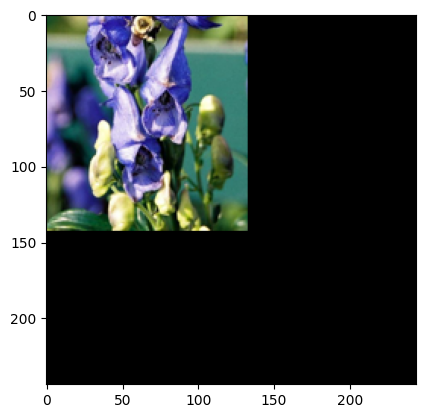

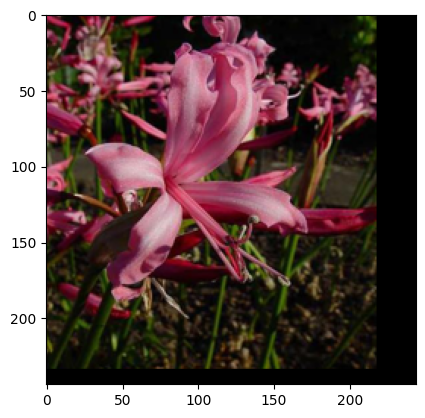

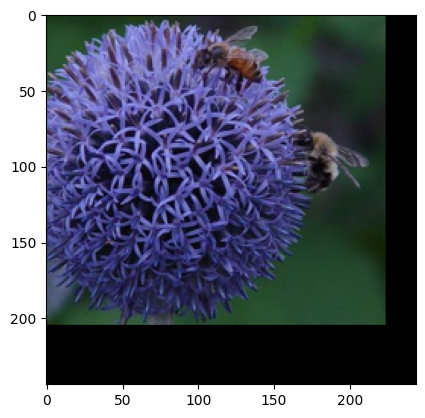

In [33]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    if isinstance(image, np.ndarray):  
        image = image.transpose((1, 2, 0))  # No need for .numpy() if it's already a NumPy array
    else:
        image = image.numpy().transpose((1, 2, 0))  # Convert PyTorch tensor to NumPy array

    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image("flowers/test/9/image_06413.jpg"))
imshow(process_image("flowers/test/37/image_03734.jpg"))
imshow(process_image("flowers/test/10/image_07090.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [51]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    model.to("cpu")
    model.eval()
    
    #convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), axis=0)).float()
    
     # Find probabilities (results) by passing through the function
    log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 results
    top_probs, top_labels = linear_probs.topk(topk)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] # This is not the correct way to do it but the correct way isnt working thanks to cpu/gpu issues so I don't care.
    top_labels = np.array(top_labels.detach())[0]
    
    #convert to classes
    idx_to_class={val:key for key,val in model.class_to_idx.items()}
    
    top_labels=[idx_to_class[lab] for lab in top_labels]
    top_flowers=[cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

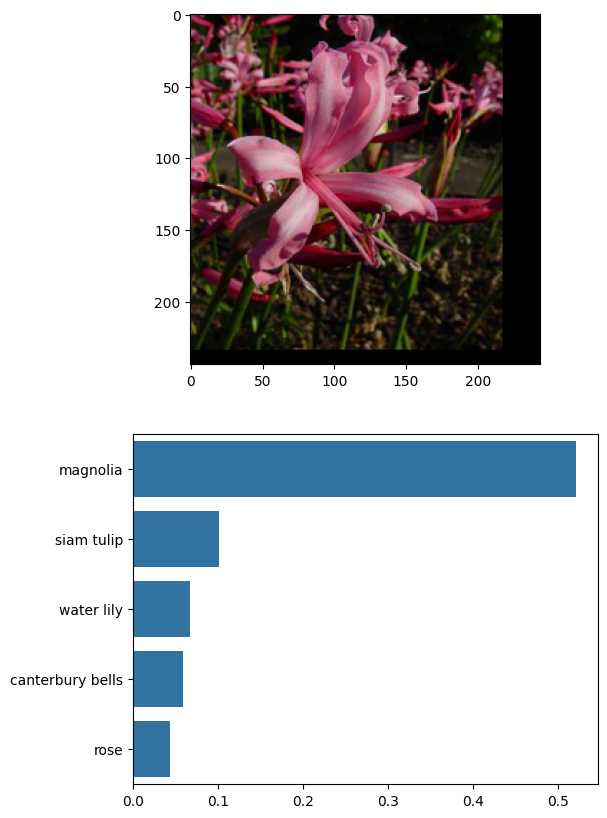

In [52]:
# TODO: Display an image along with the top 5 classes
image_path="flowers/test/37/image_03734.jpg"

plt.figure(figsize=(6,10))
ax=plt.subplot(2,1,1)

flowers_num=image_path.split('/')[2]
title_=cat_to_name[flower_num]

#plot flower
img=process_image(image_path)
imshow(img,ax,title=title_)

#make prediction
probs,labs,flowers=predict(image_path, model)

#plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs,y=flowers, color=sns.color_palette()[0]);
plt.show()

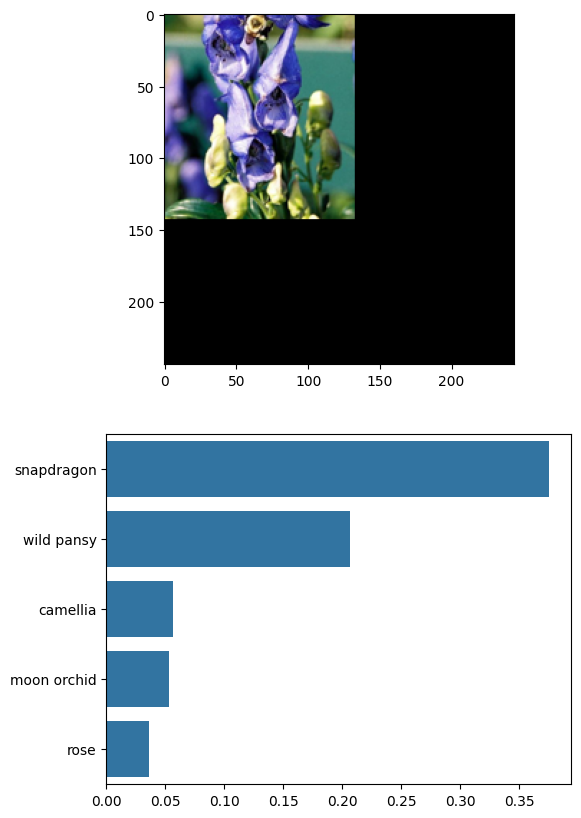

In [53]:
image_path='flowers/test/9/image_06413.jpg'
plt.figure(figsize=(6,10))
ax=plt.subplot(2,1,1)
flower_num=image_path.split('/')[2]
title_=cat_to_name[flower_num]
img = process_image(image_path)
imshow(img, ax, title = title_);
probs, labs, flowers = predict(image_path, model) 
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [1]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace
!rm checkpoint.pth